In [2]:
'''
Programmer: Mike Kovacevich
Last edited: 11/9/20
E-mail: mgk56@drexel.edu

Stacking sensitivity for different time windows and different gamma (spectral indices). Gamma will range from 2-3 and the time windows will range from 10^(-2) seconds to 10^5 seconds. Stacking sensitivity will be performed with Csky likelihood software.  
'''

import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import argparse
import histlite as hl
import csky as cy

#Building/loading MESC data from analysis directory

ana_dir = cy.utils.ensure_dir('/data/user/mkovacevich/FRB_analysis/cascades_ana')
repo = cy.selections.Repository()
ana = cy.get_analysis(repo, cy.selections.MESEDataSpecs.mesc_7yr, dir=ana_dir)

Setting up Analysis for:
MESC_2010_2016
Setting up MESC_2010_2016...
Reading /data/ana/analyses/mese_cascades/version-001-p02/IC86_2013_MC.npy ...
Reading /data/ana/analyses/mese_cascades/version-001-p02/IC79_exp.npy ...
Reading /data/ana/analyses/mese_cascades/version-001-p02/IC86_2011_exp.npy ...
Reading /data/ana/analyses/mese_cascades/version-001-p02/IC86_2012_exp.npy ...
Reading /data/ana/analyses/mese_cascades/version-001-p02/IC86_2013_exp.npy ...
Reading /data/ana/analyses/mese_cascades/version-001-p02/IC86_2014_exp.npy ...
Reading /data/ana/analyses/mese_cascades/version-001-p02/IC86_2015_exp.npy ...
Reading /data/ana/analyses/mese_cascades/version-001-p02/IC86_2016_exp.npy ...
Reading /data/ana/analyses/mese_cascades/version-001-p02/GRL/IC79_exp.npy ...
Reading /data/ana/analyses/mese_cascades/version-001-p02/GRL/IC86_2011_exp.npy ...
Reading /data/ana/analyses/mese_cascades/version-001-p02/GRL/IC86_2012_exp.npy ...
Reading /data/ana/analyses/mese_cascades/version-001-p02/GRL/

In [3]:
#Directories to store the trials
trials_dir = cy.utils.ensure_dir('/data/user/mkovacevich/FRB_analysis/trials')
sig_dir = cy.utils.ensure_dir('{}/centered_dt_sig'.format(trials_dir))
bg_dir = cy.utils.ensure_dir('{}/centered_dt_bg'.format(trials_dir))

#Calculating sensitivities, 3sigma at 90% and discovery potential as functions of different time windows for 1 FRB
#The time windows will range from ~1 ms to 10^4 seconds (following previous times windows)
cy.CONF['ana'] = ana
cy.CONF['mp_cpus'] = 5.0

#dt = 0.1
#gamma = 3.0

#loading analysis object to get mjd of time data-set and events
a = ana.anas[0]

#good_indices represents an array that tracks the indices of FRB events that fall within livetime of MESC 7 yr
FRB_mjd_time = [57760.83732799769, 57547.161818148146, 57488.35670925926, 57464.37542280093, 57389.35323349537, 57386.67762181713, 57362.262416412035, 57241.74578506944, 57183.22707634259, 57130.18688260417, 57068.86228835648, 56791.718183564815, 56600.752907407405, 56502.376286921295, 56471.165279837965, 56469.62221957176, 56202.5481300463, 55953.341223668984, 55745.79144221065, 55738.89811894676, 55704.629394675925, 55612.080417777775]

FRB_ra_rad = [2.979102500229121, 1.992642407001926, 2.2750366799746087, 2.0673424989872835, 5.928883469024737, 2.534392606820966, 5.067563483165536, 5.945115031068284, 2.811899957888065, 1.9050268785518107, 4.788485335771643, 5.9082885838512045, 1.7634806762150708, 3.5838590860451562, 2.369458992507502, 4.306948995146407, 4.776966162708479, 6.087184832180623, 6.1559508047091995, 5.514018705825685, 5.695009349257497, 5.910732044803997]

FRB_dec_rad = [-0.08691739674931762, -0.6841690667817772, 0.10611601852125524, -0.4954989746411902, -0.5204571829447091, -0.0445058959258554, -0.06754424205218056, -0.9585348251952858, -0.6965609044709369, -0.33143802495372315, -0.054105206811824215, -0.2040289895581371, -0.8852309966115239, -0.06981317007977318, 0.060039326268604934, -0.11414453308042916, -1.4800392056911915, -0.3066543495754037, -0.01972222054753592, -0.755029434412747, 0.00027925268031909274, -0.20245819323134223]

#FRB_time_window = np.ones_like(FRB_ra_rad)*dt/86400.

In [3]:
print("Starting Trials")

##### Defining functions to compute flux ######    
def ndarray_to_TSD(trials):
    return cy.dists.TSD(cy.utils.Arrays(trials))

def tsd_merge(x):
    ts_values = np.concatenate([xx[0] for xx in x])
    n_zero = sum(xx[1] for xx in x)
    return cy.dists.TSD(ts_values, n_zero=n_zero)

def find_n_sig(beta=0.9, nsigma=None):
    # get signal trials, background distribution, and trial runner
    sig_trials = cy.bk.get_best(sig, 'n_sig')
    #b = cy.bk.get_best(bg) #, 'gamma', gamma, 'dt', dt)
    b = bg
    src = cy.sources(FRB_ra_rad, FRB_dec_rad, mjd = FRB_mjd_time, sigma_t = np.zeros_like(FRB_ra_rad), t_100 = FRB_time_window)
    conf = {'extended':True, 'space':"ps",'time':"transient",'sig':"transient",'flux': cy.hyp.PowerLawFlux(gamma),'box_mode':'center'}
    tr = cy.get_trial_runner(conf, src = src, ana=ana)
    # determine ts threshold
    if nsigma is not None:
        ts = b.isf_nsigma(nsigma)
    else:
        ts = b.median()
    # include background trials in calculation
    trials = {0: tr.get_many_fits(10000)}
    trials.update(sig_trials)
    # get number of signal events
    # (arguments prevent additional trials from being run)
    result = tr.find_n_sig(ts, beta, max_batch_size=0, logging=False, trials=trials, n_bootstrap=1)
    # return flux
    return tr.to_E2dNdE(result, E0=1e5)

Starting Trials


In [22]:
#elif args.choose == 3:
#bg = cy.bk.get_all(
#'{}/'.format(bg_dir),'bg*npy',
bg = cy.bk.get_all(
    '/data/user/mkovacevich/FRB_analysis/trials/centered_dt_bg/dt/0.1/',
    'bg_trials_seed_*.0.npy',
    pre_convert=lambda x: (x['ts'][x['ts'] > 0], np.sum(x['ts'] == 0)),
    merge = tsd_merge,
    log=True)
    #'{}/'.format(sig_dir),'sig*npy'

500 files loaded.                                                                            


In [32]:
sig = cy.bk.get_all('/data/user/mkovacevich/FRB_analysis/trials/centered_dt_sig/gamma/3.0/dt/0.1/','sig*npy', merge=np.concatenate, post_convert=cy.utils.Arrays)

190 files loaded.                                                                                             


In [28]:
time_windows = [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0, 100000.0]
centered_sens_gamma3_plot = []
for i in time_windows:
    print(i)
    fluxs_sens = []
    dt = i
    FRB_time_window = np.ones_like(FRB_ra_rad)*dt/86400.
    gamma = 3.0
    bg = cy.bk.get_all(
    '/data/user/mkovacevich/FRB_analysis/trials/weighted_livetime_bg/dt/'+str(i)+'/',
    'bg_trials_seed_*.0.npy',
    pre_convert=lambda x: (x['ts'][x['ts'] > 0], np.sum(x['ts'] == 0)),
    merge = tsd_merge,
    log=True)
    sig = cy.bk.get_all('/data/user/mkovacevich/FRB_analysis/trials/centered_dt_sig/gamma/3.0/dt/'+str(i)+'/','sig*npy', merge=np.concatenate, post_convert=cy.utils.Arrays)
    fluxs_sens = find_n_sig(beta=0.9)
    centered_sens_gamma3_plot.append(fluxs_sens)
    print('sens = ' + str(fluxs_sens))
    

0.01
500 files loaded.                                                                                   
190 files loaded.                                                                                              
Performing 10000 background trials using 5.0 cores:
      10000/10000 trials complete.   
sens = 0.11144343920669741
0.1
500 files loaded.                                                                                  
190 files loaded.                                                                                             
Performing 10000 background trials using 5.0 cores:
      10000/10000 trials complete.   
sens = 0.10888811117462528
1.0
500 files loaded.                                                                                  
190 files loaded.                                                                                             
Performing 10000 background trials using 5.0 cores:
      10000/10000 trials complete.   
sens = 0.1096015160262683
10

999985407.0
1000000000


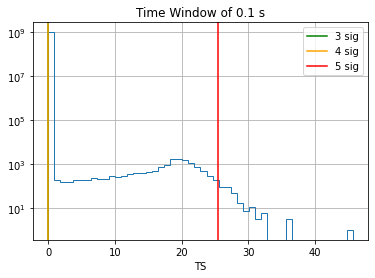

In [58]:
add_zero = 1e9 - len(bg.trials.ts)

print(add_zero)
x = np.zeros(int(add_zero))
y = np.append(x, bg.trials.ts)
#print(len(bg.trials.ts))
print(len(y))
plt.hist(y,bins=50,histtype='step')
plt.axvline(bg.isf_nsigma(3),color='green', label = '3 sig')
plt.axvline(bg.isf_nsigma(4),color='orange', label = '4 sig')
plt.axvline(bg.isf_nsigma(5),color='red',label = '5 sig')
plt.yscale('log')
plt.legend(loc='upper right')
plt.xlabel(r'TS')
plt.title(r'Time Window of 0.1 s')
plt.grid()


In [33]:
fluxs_sens = []
fluxs_sens = find_n_sig(beta=0.9)

print('sens = ' + str(fluxs_sens))
#np.save('/data/user/mkovacevich/FRB_analysis/sens_gamma_'+str(gamma)+'dt'+str(dt),fluxs_sens,allow_pickle=True)
'''
fluxs_3sig_disc,fluxs_4sig_disc = [],[]
fluxs_3sig_disc = find_n_sig(beta=0.9,nsigma=3)
print('3sig = ' + str(fluxs_3sig_disc))
#np.save('/data/user/mkovacevich/FRB_analysis/3sig_gamma_'+str(gamma)+'dt'+str(dt),fluxs_3sig_disc,allow_pickle=True)
    
fluxs_4sig_disc = find_n_sig(beta=0.9,nsigma=4)
#np.save('data/user/mkovacevich/FRB_analysis/4sig_gamma_'+str(gamma)+'dt'+str(dt),fluxs_4sig_disc,allow_pickle=True)
print('4sig = ' + str(fluxs_4sig_disc))

fluxs_5sig_disc = []
fluxs_5sig_disc = find_n_sig(beta = 0.9, nsigma=5)
print('5sig = ' + str(fluxs_5sig_disc))
#np.save('5sig_gamma_'+str(gamma)+'dt'+str(dt),fluxs_5sig_disc,allow_pickle=True)
'''
    

Performing 100000 background trials using 5.0 cores:
     100000/100000 trials complete.   
sens = 0.10888814287293792


"\nfluxs_3sig_disc,fluxs_4sig_disc = [],[]\nfluxs_3sig_disc = find_n_sig(beta=0.9,nsigma=3)\nprint('3sig = ' + str(fluxs_3sig_disc))\n#np.save('/data/user/mkovacevich/FRB_analysis/3sig_gamma_'+str(gamma)+'dt'+str(dt),fluxs_3sig_disc,allow_pickle=True)\n    \nfluxs_4sig_disc = find_n_sig(beta=0.9,nsigma=4)\n#np.save('data/user/mkovacevich/FRB_analysis/4sig_gamma_'+str(gamma)+'dt'+str(dt),fluxs_4sig_disc,allow_pickle=True)\nprint('4sig = ' + str(fluxs_4sig_disc))\n\nfluxs_5sig_disc = []\nfluxs_5sig_disc = find_n_sig(beta = 0.9, nsigma=5)\nprint('5sig = ' + str(fluxs_5sig_disc))\n#np.save('5sig_gamma_'+str(gamma)+'dt'+str(dt),fluxs_5sig_disc,allow_pickle=True)\n"

In [ ]:
#gamma = 2
centered_sens_plot = [0.45039610769724353, 0.42811340366870104, 0.4345044973793576, 0.4324263955864112, 0.43223290118101687, 0.4245982609723475, 0.3998979445747711,0.3985009152674313]
#three_sig_disc = [0.42776688714680017, 0.42811340366870104, 0.43450396388872475, 0.4324249009717406, 0.46812358160803386, 0.5831215317618084, 0.7534076519103213, 0.9961235028455266]
#four_sig_disc = [0.42776683421012157, 0.42811340366870104, 0.45305475235563125, 0.4974615930177303, 0.6206451539256346, 0.7446077402713749, 0.9952820464068196, 1.2897870066683734]
#five_sig_disc = [0.45317406436880914, 0.5099723283130988, 0.6156788971106276, 0.6911145552319602,0.7714121972903091, 0.9031212184256271, 1.2121937416232829,1.707514275433391]


#gamma = 3 sensitivity/disc potential
centered_sens_gamma3_plot = [0.11144343920669741,0.10888814287293792,0.10960143262343891, 0.09850424768248242,  ]
#three_sig_3_disc = [0.10589442849608482, 0.10774932384293899, 0.10652668411843542, 0.10898250232811543, 0.14319124513467263, 0.18549418622378533, 0.2888153531188422, 0.4603323851012091 ]
#four_sig_3_disc = [0.10589444154663731, 0.10774932384293899, 0.12838927877321235,0.16016783223579056, 0.19136432463531847, 0.24338816172234576, 0.3788477434595977, 0.595483965117286]
#five_sig_3_disc = [0.12999025421058874, 0.15880513171845506, 0.17813135333658375, 0.1885987653714965, 0.233225098296703, 0.30692166510400665, 0.45367638098436147, 0.7707842113625186]

In [10]:
l2p2_gamma2_sens_t = [0.011121256211835899,
0.017012542798525893,
0.025417229195937745,
0.03797407287373919,
0.05541020330009495,
0.08278444050080813,
0.12966432776590128,
0.19372224225344342,
0.2826715180829791,
0.41246263829013563,
0.6460355399988293,
0.9426684551178854,
1.4083738370720185,
2.055041103812236,
3.07029062975785,
3.981071705534973]
l2p2_gamma2_sens = [0.0015893498753677647,
0.0015893498753677647,
0.0015893498753677647,
0.0015893498753677647,
0.0015671910803783098,
0.0015671910803783098,
0.0015453412244103959,
0.0015237960002208247,
0.0015237960002208247,
0.001502551160618197,
0.0014816025176256627,
0.0014816025176256627,
0.0015671910803783098,
0.0017049330007751422,
0.0018547811900706149,
0.001989667416330628]

l2p2_gamma2_3sig_t = [0.010360593046256347,
0.01584893192461114,
0.024244620170823294,
0.036222161198834195,
0.05162029864860425,
0.08085228676856247,
0.11522280977398217,
0.17214619820847707,
0.2453260067494098,
0.35796960610421735,
0.5223345074266843,
0.780382806346953,
1.11212562118359,
1.5848931924611143,
2.312610877827063,
3.3744665556542053]
l2p2_gamma2_3sig = [0.002388079499862219,
0.0025617490590909555,
0.002709735052292361,
0.0027869036298334,
0.002906796537132131,
0.0030318472507743135,
0.0032069896696027963,
0.0034888550536740642,
0.0037954938554743277,
0.004187465283537237,
0.004491992519803661,
0.004886798031290245,
0.005391471540435076,
0.005948264115930042,
0.006562558241753381,
0.007240292266287758]

l2p2_gamma2_4sig_t = [0.010360593046256347,
0.016227679071960238,
0.02367876101822715,
0.0345510729459222,
0.05162029864860425,
0.07712221373679749,
0.11522280977398217,
0.17214619820847707,
0.25118864315095824,
0.36652412370796295,
0.5223345074266843,
0.780382806346953,
1.1387024535228745,
1.6227679071960237,
2.312610877827063,
3.5376751318342863]
l2p2_gamma2_4sig = [0.0029895770856517914,
0.003252333870135688,
0.0034888550536740642,
0.0036903976983064437,
0.003903582969812255,
0.004071515547789694,
0.004306717067640523,
0.00468523854273686,
0.005097028631688913,
0.005545011344733064,
0.005948264115930042,
0.006471062728437459,
0.0070398106101623725,
0.007876648466548973,
0.008568934620839328,
0.009723102813046851]

l2p2_gamma2_5sig_t = [0.010861690808398172,
0.017419097138259683,
0.024244620170823294,
0.035376751318342864,
0.052853885930792474,
0.0789652286849973,
0.11522280977398217,
0.17214619820847707,
0.2571913809059347,
0.37528307143701783,
0.5348169072244053,
0.7990318713533598,
1.1659144011798324,
1.7012542798525891,
2.482400184600118,
3.5376751318342863]
l2p2_gamma2_5sig = [0.003958776427607793,
0.004129083434341263,
0.004367610510548835,
0.004619916714010398,
0.004886798031290245,
0.005169096431154509,
0.005545011344733064,
0.006032367686157233,
0.006471062728437459,
0.0070398106101623725,
0.007551770453120379,
0.008215502768619369,
0.008937571151054249,
0.009860579502771048,
0.010878909547925617,
0.012002405428472824]

Tracks_6yr_gamma2_sens_t = [0.010861690808398172,
0.015479024575053759,
0.025417229195937745,
0.039810717055349734,
0.06537092275705862,
0.1000000000000001,
0.2030917620904737,
0.310675990983383,
0.6614740641230159,
1.11212562118359,
1.7012542798525891,
3.5376751318342863,
5.809015885375252,
10.734188827013528,
14.940288172641718,
30.342494511212667,
48.66082717980363,
81.81265992098253,
134.33993325989016,
210.41510980665112,
292.86445646252434,
669.3311323346339,
1099.0707273598882,
1721.4619820847743,
2396.0020179511844,
4223.193938357813,
6614.740641230159,
9882.613136726344,
15848.931924611174,
29986.31348575573,
70170.38286703837,
97666.04241019613]
Tracks_6yr_gamma2_sens = [0.014609459416553588,
0.014405773606943369,
0.014405773606943369,
0.014405773606943369,
0.014405773606943369,
0.014609459416553588,
0.014405773606943369,
0.014405773606943369,
0.014609459416553588,
0.014609459416553588,
0.014609459416553588,
0.014816025176256633,
0.014609459416553588,
0.014816025176256633,
0.014816025176256633,
0.014816025176256633,
0.014816025176256633,
0.014816025176256633,
0.015025511606181971,
0.015025511606181971,
0.015237960002208254,
0.015453412244103959,
0.01567191080378309,
0.015893498753677647,
0.016118219775228444,
0.016346118167496003,
0.016577238855893187,
0.01704933000775143,
0.017534865500829593,
0.018547811900706156,
0.021046056487469784,
0.022261835824332818]

Tracks_6yr_gamma2_3sig_t = [0.010608183551394488,
0.013433993325989008,
0.01869798778781705,
0.029286445646252372,
0.046967221820749486,
0.08085228676856247,
0.13593563908785256,
0.2285463864134993,
0.393433915353694,
0.5740825670026142,
0.9206669731629717,
1.4764908816142583,
2.7283333764867694,
4.696722182074949,
8.085228676856243,
9.316027658125524,
12.079564637393885,
17.62600326175461,
25.719138090593468,
40.283593523865605,
61.623106765027,
94.26684551178855,
134.33993325989016,
220.5919925559487,
314.3662376389418,
469.6722182074949,
669.3311323346339,
1000,
1425.1026703029993,
2232.1221068157756,
3106.759909833836,
4866.082717980364,
7621.690026086907,
10360.593046256343,
15479.024575053798,
21544.346900318866,
29986.31348575573,
38881.55180308093,
55410.20330009503,
73564.22544596436,
97666.04241019613]
Tracks_6yr_gamma2_3sig = [0.014405773606943369,
0.014405773606943369,
0.014405773606943369,
0.014405773606943369,
0.014405773606943369,
0.014609459416553588,
0.014405773606943369,
0.014405773606943369,
0.014405773606943369,
0.014609459416553588,
0.014609459416553588,
0.014609459416553588,
0.014609459416553588,
0.014609459416553588,
0.014816025176256633,
0.015237960002208254,
0.015237960002208254,
0.015453412244103959,
0.015893498753677647,
0.016346118167496003,
0.01704933000775143,
0.017782794100389247,
0.018547811900706156,
0.01989667416330628,
0.021046056487469784,
0.02195146020234702,
0.023219542502889837,
0.02456087882417329,
0.025979700872256498,
0.027480484808533455,
0.028662698352770934,
0.030747150813218382,
0.03298319200430066,
0.03488855053674064,
0.03795493855474327,
0.04071515547789694,
0.04367610510548835,
0.046199167140103976,
0.0502596560506688,
0.05467702520850777,
0.05865333121860829]

Tracks_6yr_gamma2_4sig_t = [0.010608183551394488,
0.021544346900318846,
0.030702906297578512,
0.038881551803080915,
0.07712221373679749,
0.10734188827013538,
0.17626003261754594,
0.2696306326783704,
0.41246263829013563,
0.677281527744142,
1.1387024535228745,
1.74190971382597,
2.860291242530776,
4.480041647123619,
7.3564225445964215,
10.990707273598881,
17.214619820847705,
30.342494511212667,
52.23345074266843,
81.81265992098253,
144.20302106200558,
220.5919925559487,
362.2216119883423,
541.1695265464638,
953.865584007017,
1603.7187437513342,
2453.2600674941054,
4752.510411057916,
8181.265992098251,
12814.223889440853,
19144.819761699575,
27935.33257985228,
38881.55180308093,
62355.07341273912,
84762.76754730681,
97666.04241019613]
Tracks_6yr_gamma2_4sig = [0.014405773606943369,
0.014609459416553588,
0.014816025176256633,
0.014609459416553588,
0.014816025176256633,
0.014816025176256633,
0.015025511606181971,
0.015237960002208254,
0.015453412244103959,
0.015893498753677647,
0.016577238855893187,
0.017290393534132746,
0.018289217384935594,
0.019076021571856637,
0.020177996797972025,
0.021046056487469784,
0.02195146020234702,
0.022895814486771665,
0.02456087882417329,
0.025260330263315263,
0.025979700872256498,
0.02671955791457426,
0.027869036298334014,
0.029067965371321308,
0.031181890277927123,
0.03392249638669098,
0.03588211624166497,
0.03958776427607792,
0.04367610510548835,
0.047514839684829946,
0.051690964311545094,
0.05623413251903497,
0.06032367686157236,
0.06844880234698683,
0.07240292266287758,
0.07658546286248345]

Tracks_6yr_gamma2_5sig_t = [0.010360593046256347,
0.016227679071960238,
0.0345510729459222,
0.06384519314384515,
0.12966432776590128,
0.21291444569928009,
0.36652412370796295,
0.560683723358313,
0.8181265992098243,
1.4420302106200558,
2.7935332579852252,
5.411695265464643,
12.663801734674047,
27.607408473246647,
47.525104110579065,
74.43803013251696,
131.20449619143295,
231.2610877827063,
370.877741177448,
669.3311323346339,
1000,
1459.158818289775,
2232.1221068157756,
4124.626382901356,
5878.0160722749115,
9651.957137350706,
13755.029890088583,
23678.76101822716,
38881.55180308093,
55410.20330009503,
84762.76754730681,
97666.04241019613]
Tracks_6yr_gamma2_5sig = [0.016577238855893187,
0.01704933000775143,
0.018289217384935594,
0.01989667416330628,
0.02134363044439261,
0.022261835824332818,
0.023219542502889837,
0.02354784776732912,
0.02388079499862219,
0.02421844983036866,
0.02490814948276735,
0.025260330263315263,
0.025979700872256498,
0.0270973505229236,
0.02826308158714424,
0.029478962532732043,
0.031622776601683826,
0.03392249638669098,
0.03588211624166497,
0.03795493855474327,
0.040147502755748646,
0.041874652835372395,
0.044919925198036614,
0.04886798031290245,
0.05242183210126625,
0.057029236976621836,
0.061176604118064325,
0.06844880234698683,
0.07551770453120371,
0.08215502768619368,
0.09063941068111253,
0.0945387283130795]

In [5]:
#####Data from webplot digitizer for Gamma = 3#####
l2p2_gamma3_sens_t = [0.010608183551394488,
0.016227679071960238,
0.024244620170823294,
0.03797407287373919,
0.05947835851664276,
0.08476276754730665,
0.12966432776590128,
0.19372224225344342,
0.28942661247167517,
0.42231939383578126,
0.6614740641230159,
0.9882613136726325,
1.375502989008857,
2.0070773159962125,
2.99863134857557,
3.981071705534973] 
l2p2_gamma3_sens = [0.00010878909547925617,
0.00011188722115874222,
0.00011188722115874222,
0.00011032728395799045,
0.00011032728395799045,
0.00011032728395799045,
0.00011188722115874222,
0.0001134692145905821,
0.00011670062198491273,
0.00011835067295194702,
0.00012172109585547045,
0.0001234421322005103,
0.00013241927918860452,
0.00014204927595018585,
0.00015453412244103957,
0.00016346118167496001]

l2p2_gamma3_3sig_t=[0.010861690808398172,
0.016227679071960238,
0.02367876101822715,
0.036222161198834195,
0.0541169526546464,
0.08085228676856247,
0.12079564637393898,
0.17214619820847707,
0.25118864315095824,
0.36652412370796295,
0.5223345074266843,
0.7621690026086899,
1.11212562118359,
1.6227679071960237,
2.3678761018227137,
3.455107294592218]
l2p2_gamma3_3sig = [0.000168116274010413,
0.00018289217384935593,
0.0001934574085275195,
0.00020177996797972027,
0.00021046056487469762,
0.0002226183582433282,
0.0002421844983036866,
0.0002634703250955546,
0.0002906796537132131,
0.00032069896696027965,
0.0003488855053674064,
0.0003849159021949685,
0.0004306717067640523,
0.0004685238542736865,
0.0005169096431154509,
0.0005702923697662186]

l2p2_gamma3_4sig_t = [0.011121256211835899,
0.016227679071960238,
0.023126108778270607,
0.035376751318342864,
0.052853885930792474,
0.08085228676856247,
0.11522280977398217,
0.1681283789498308,
0.2453260067494098,
0.35796960610421735,
0.510143441546433,
0.7443803013251696,
1.0861690808398177,
1.6227679071960237,
2.312610877827063,
3.2957079373631073]
l2p2_gamma3_4sig = [0.00021645411852715715,
0.00022895814486771664,
0.00024908149482767364,
0.0002671955791457426,
0.0002826308158714424,
0.00029895770856517916,
0.00032069896696027965,
0.0003538184599286097,
0.0003849159021949685,
0.00042466726041410325,
0.0004619916714010397,
0.0005097028631688908,
0.0005623413251903496,
0.000620415910655883,
0.0006749448574119245,
0.0007342664053621871]

l2p2_gamma3_5sig_t = [0.010861690808398172,
0.017012542798525893,
0.024824001846001194,
0.036222161198834195,
0.05541020330009495,
0.08085228676856247,
0.11522280977398217,
0.1681283789498308,
0.2453260067494098,
0.35796960610421735,
0.510143441546433,
0.7443803013251696,
1.11212562118359,
1.6227679071960237,
2.258635520721379,
3.2957079373631073]
l2p2_gamma3_5sig = [0.0002826308158714424,
0.00029895770856517916,
0.00031622776601683826,
0.00033922496386690985,
0.00036389459900993966,
0.00037954938554743276,
0.000407151554778969,
0.00044919925198036616,
0.0004886798031290245,
0.000539147154043507,
0.0005865333121860825,
0.0006471062728437453,
0.0007039810610162372,
0.000776683184197858,
0.0008449466108283339,
0.0009192097752027743]

Tracks_6yr_gamma3_sens_t = [0.010861690808398172,
0.013433993325989008,
0.021544346900318846,
0.029286445646252372,
0.040762086875748886,
0.05947835851664276,
0.08476276754730665,
0.1266380173467405,
0.19372224225344342,
0.28942661247167517,
0.4641588833612782,
0.7100387508468508,
1.1387024535228745,
1.5479024575053781,
2.1544346900318865,
3.455107294592218,
5.673435918225605,
7.896522868499733,
14.591588182897716,
23.400803470013493,
51.01434415464325,
85.76958985908945,
134.33993325989016,
210.41510980665112,
370.877741177448,
594.783585166427,
953.865584007017,
1425.1026703029993,
2180.0253234900542,
4028.3593523865607,
6772.815277441413,
11387.024535228735,
19602.32982646281,
29986.31348575573,
39810.71705534977,
59478.35851664282,
88862.38162743408,
97666.04241019613]
Tracks_6yr_gamma3_sens = [0.005169096431154509,
0.005169096431154509,
0.005169096431154509,
0.005242183210126622,
0.005169096431154509,
0.005169096431154509,
0.005169096431154509,
0.005169096431154509,
0.005169096431154509,
0.005242183210126622,
0.005242183210126622,
0.005242183210126622,
0.005242183210126622,
0.00531630337613875,
0.00531630337613875,
0.00531630337613875,
0.00531630337613875,
0.00531630337613875,
0.00531630337613875,
0.005391471540435076,
0.005391471540435076,
0.005467702520850777,
0.005545011344733064,
0.005545011344733064,
0.005623413251903497,
0.005702923697662186,
0.0057835583558344976,
0.005865333121860826,
0.006032367686157233,
0.006291880821827283,
0.006562558241753381,
0.006941661220595722,
0.007446483293967068,
0.008215502768619369,
0.008937571151054249,
0.010141391788575694,
0.011507357611050628,
0.011835067295194701]

Tracks_6yr_gamma3_3sig_t = [0.011121256211835899,
0.017012542798525893,
0.02602463309528382,
0.042733575421093226,
0.06853263589031834,
0.11253355826007658,
0.19372224225344342,
0.37528307143701783,
0.5740825670026142,
0.8781925400320679,
1.5479024575053781,
2.5417229195937745,
4.696722182074949,
7.532221397586247,
12.966432776590143,
18.478497974222947,
28.26715180829791,
42.23193938357812,
71.00387508468508,
134.33993325989016,
210.41510980665112,
321.87875118212355,
492.3882631706742,
753.2221397586263,
1359.3563908785297,
2129.144456992803,
3181.0031748655183,
4982.369099735708,
7990.318713533615,
11937.766417144383,
17419.097138259684,
24244.620170823357,
33744.66555654209,
50415.50277041562,
73564.22544596436,
95386.5584007015]
Tracks_6yr_gamma3_3sig = [0.005169096431154509,
0.005169096431154509,
0.005169096431154509,
0.005169096431154509,
0.005169096431154509,
0.005169096431154509,
0.005169096431154509,
0.005242183210126622,
0.005242183210126622,
0.005242183210126622,
0.00531630337613875,
0.00531630337613875,
0.00531630337613875,
0.005467702520850777,
0.005623413251903497,
0.005702923697662186,
0.005865333121860826,
0.006032367686157233,
0.006562558241753381,
0.007551770453120379,
0.008100961820520693,
0.008812963089664328,
0.009322066466219915,
0.009860579502771048,
0.010727235250077552,
0.011507357611050628,
0.01234421322005103,
0.013429157906124263,
0.015025511606181971,
0.016577238855893187,
0.018289217384935594,
0.01961927374280121,
0.02195146020234702,
0.02490814948276735,
0.027864838763187683,
0.030821528043608014]

Tracks_6yr_gamma3_4sig_t = [0.010118781198504508,
0.017835367040982146,
0.029986313485755686,
0.048089612993109654,
0.06693311323346332,
0.10238973294320834,
0.1566288628412433,
0.2453260067494098,
0.393433915353694,
0.6162310676502707,
1.1659144011798324,
1.7012542798525891,
2.5417229195937745,
4.58710267823439,
7.184726762278733,
11.797632721724142,
19.372224225344322,
33.34854751235192,
51.01434415464325,
79.90318713533598,
147.649088161426,
236.78761018227158,
407.6208687574893,
653.7092275705868,
1023.8973294320855,
1327.629589221128,
1937.2224225344323,
3181.0031748655183,
5101.434415464335,
7621.690026086907,
12814.223889440853,
19144.819761699575,
32957.07937363111,
46967.22182074959,
71847.2676227874,
97666.04241019613]
Tracks_6yr_gamma3_4sig = [0.005242183210126622,
0.005242183210126622,
0.005242183210126622,
0.005242183210126622,
0.005242183210126622,
0.00531630337613875,
0.005391471540435076,
0.005545011344733064,
0.005702923697662186,
0.0057835583558344976,
0.006204159106558829,
0.006562558241753381,
0.0070398106101623725,
0.007766831841978581,
0.008215502768619369,
0.008690092320062187,
0.008937571151054249,
0.009192097752027742,
0.00945387283130795,
0.009723102813046851,
0.010141391788575694,
0.010727235250077552,
0.011507357611050628,
0.012172109585547052,
0.01324192791886046,
0.013811597145825198,
0.014816025176256633,
0.016118219775228444,
0.017534865500829593,
0.01934574085275197,
0.021645411852715738,
0.02388079499862219,
0.02826308158714424,
0.031181890277927123,
0.03588211624166497,
0.040147502755748646]

Tracks_6yr_gamma3_5sig_t = [0.010360593046256347,
0.013433993325989008,
0.019602329826462782,
0.03218787511821236,
0.046967221820749486,
0.1099070727359887,
0.17626003261754594,
0.37528307143701783,
0.6018484958761152,
1.3433993325989015,
2.205919925559485,
4.480041647123619,
6.537092275705868,
13.593563908785269,
22.85463864134993,
41.246263829013564,
71.00387508468508,
119.37766417144383,
210.41510980665112,
337.4466555654209,
541.1695265464638,
888.6238162743407,
1529.7321160913598,
2340.0803470013493,
3842.513346254327,
5475.976030421955,
7621.690026086907,
10861.690808398187,
17835.36704098217,
25417.229195937743,
38881.55180308093,
60899.7324441946,
97666.04241019613]
Tracks_6yr_gamma3_5sig = [0.006204159106558829,
0.006380842850117603,
0.006655347426496741,
0.0070398106101623725,
0.007551770453120379,
0.008331663231669726,
0.008568934620839328,
0.008812963089664328,
0.008937571151054249,
0.009192097752027742,
0.009192097752027742,
0.009322066466219915,
0.00945387283130795,
0.009860579502771048,
0.010141391788575694,
0.010878909547925617,
0.011835067295194701,
0.01269575510760524,
0.01361903517166549,
0.014405773606943369,
0.015237960002208254,
0.016346118167496003,
0.017782794100389247,
0.01934574085275197,
0.021046056487469784,
0.022576599902750884,
0.02421844983036866,
0.026347032509555487,
0.029478962532732043,
0.032523338701356874,
0.036389459900993966,
0.041874652835372395,
0.04886798031290245]

In [8]:
#Gamma = 2 sensitivity/disc potential
sens_plot, three_sig_disc, four_sig_disc, five_sig_disc = [],[],[],[]

sens_plot = [0.42776688714680017, 0.42811340366870104, 0.4345044973793576, 0.4324263955864112, 0.43223290118101687, 0.4245982609723475, 0.3998979445747711,0.3985009152674313]
three_sig_disc = [0.42776688714680017, 0.42811340366870104, 0.43450396388872475, 0.4324249009717406, 0.46812358160803386, 0.5831215317618084, 0.7534076519103213, 0.9961235028455266]
four_sig_disc = [0.42776683421012157, 0.42811340366870104, 0.45305475235563125, 0.4974615930177303, 0.6206451539256346, 0.7446077402713749, 0.9952820464068196, 1.2897870066683734]
five_sig_disc = [0.45317406436880914, 0.5099723283130988, 0.6156788971106276, 0.6911145552319602,0.7714121972903091, 0.9031212184256271, 1.2121937416232829,1.707514275433391]
time_window_plot = [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0, 100000.0]


#gamma = 3 sensitivity/disc potential

sens_gamma3_plot = [0.10589442849608482, 0.1077493092441084, 0.10652667073322919, 0.10898243968659185, 0.10796400059738795, 0.1055303365847919, 0.11013134071451022, 0.14649931742425515]
three_sig_3_disc = [0.10589442849608482, 0.10774932384293899, 0.10652668411843542, 0.10898250232811543, 0.14319124513467263, 0.18549418622378533, 0.2888153531188422, 0.4603323851012091 ]
four_sig_3_disc = [0.10589444154663731, 0.10774932384293899, 0.12838927877321235,0.16016783223579056, 0.19136432463531847, 0.24338816172234576, 0.3788477434595977, 0.595483965117286]
five_sig_3_disc = [0.12999025421058874, 0.15880513171845506, 0.17813135333658375, 0.1885987653714965, 0.233225098296703, 0.30692166510400665, 0.45367638098436147, 0.7707842113625186]
#gamma = 3 sensitivity per source
Num_FRBs = 22
sens_gamma_3_perFRB = [x / Num_FRBs for x in sens_gamma3_plot]
three_sig_gamma_3_perFRB = [x / Num_FRBs for x in three_sig_3_disc]
four_sig_gamma_3_perFRB = [x / Num_FRBs for x in four_sig_3_disc ]
five_sig_gamma_3_perFRB = [x / Num_FRBs for x in five_sig_3_disc ]

#gamma = 2 sensitivity per source
sens_gamma_2_perFRB = [x / Num_FRBs for x in sens_plot]
three_sig_gamma_2_perFRB = [x / Num_FRBs for x in three_sig_disc]
four_sig_gamma_2_perFRB = [x / Num_FRBs for x in four_sig_disc ]
five_sig_gamma_2_perFRB = [x / Num_FRBs for x in five_sig_disc ]


centered_sens_gamma2_perFRB = [x / Num_FRBs for x in centered_sens_gamma2_plot]

centered_sens_gamma3_perFRB = [x / Num_FRBs for x in centered_sens_gamma3_plot]

weighted_sens_gamma2_perFRB = [x / Num_FRBs for x in weighted_sens_gamma2_plot]

weighted_sens_gamma3_perFRB = [x / Num_FRBs for x in weighted_sens_gamma3_plot]



NameError: name 'centered_sens_gamma2_plot' is not defined

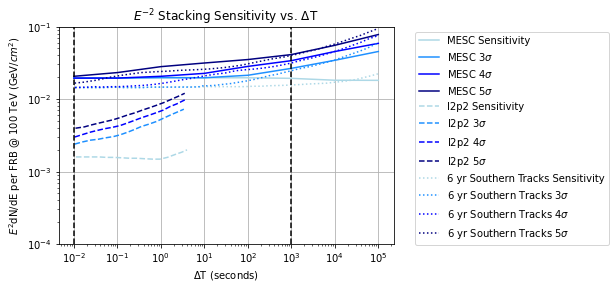

In [7]:
#### Gamma = 2

plt.plot(time_window_plot, sens_gamma_2_perFRB, color = 'lightblue', label = 'MESC Sensitivity')
plt.plot(time_window_plot, three_sig_gamma_2_perFRB,  color = 'dodgerblue', label = r'MESC 3$\sigma$')
plt.plot(time_window_plot, four_sig_gamma_2_perFRB, color = 'blue', label = r'MESC 4$\sigma$')
plt.plot(time_window_plot, five_sig_gamma_2_perFRB, color = 'navy', label = r'MESC 5$\sigma$')

plt.plot(l2p2_gamma2_sens_t, l2p2_gamma2_sens,  color = 'lightblue', linestyle='--', label = r'l2p2 Sensitivity')
plt.plot(l2p2_gamma2_3sig_t, l2p2_gamma2_3sig, color = 'dodgerblue', linestyle='--', label = r'l2p2 3$\sigma$')
plt.plot(l2p2_gamma2_4sig_t, l2p2_gamma2_4sig, color = 'blue', linestyle='--', label = r'l2p2 4$\sigma$')
plt.plot(l2p2_gamma2_5sig_t, l2p2_gamma2_5sig, color = 'navy', linestyle='--', label = r'l2p2 5$\sigma$')

plt.plot(Tracks_6yr_gamma2_sens_t, Tracks_6yr_gamma2_sens,  color = 'lightblue', linestyle=':',label = r'6 yr Southern Tracks Sensitivity')
plt.plot(Tracks_6yr_gamma2_3sig_t, Tracks_6yr_gamma2_3sig, color = 'dodgerblue', linestyle=':',label = r'6 yr Southern Tracks 3$\sigma$')
plt.plot(Tracks_6yr_gamma2_4sig_t, Tracks_6yr_gamma2_4sig, color = 'blue', linestyle=':',label = r'6 yr Southern Tracks 4$\sigma$')
plt.plot(Tracks_6yr_gamma2_5sig_t, Tracks_6yr_gamma2_5sig, color = 'navy', linestyle=':',label = r'6 yr Southern Tracks 5$\sigma$')


plt.grid('major')
plt.ylim(.0001, 0.1)
plt.yscale('log')
plt.xscale('log')
plt.axvline(x=0.01, color = 'black', linestyle='--')
plt.axvline(x=1000.0, color = 'black',  linestyle='--')
plt.ylabel(r'$E^{2}$dN/dE per FRB @ 100 TeV (GeV/$cm^{2}$)')
plt.xlabel(r'$\Delta$T (seconds)')
plt.title(r'$E^{-2}$ Stacking Sensitivity vs. $\Delta$T')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.savefig('/data/user/mkovacevich/FRB_analysis/plots/LogTicks_E2StackingSensitivity.png')

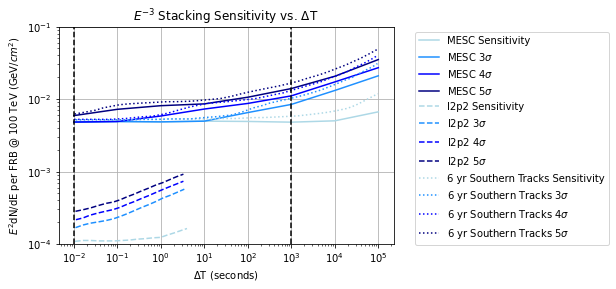

In [48]:
#### Gamma = 3

plt.plot(time_window_plot, sens_gamma_3_perFRB, color = 'lightblue', label = 'MESC Sensitivity')
plt.plot(time_window_plot, three_sig_gamma_3_perFRB, color = 'dodgerblue', label = r'MESC 3$\sigma$')
plt.plot(time_window_plot, four_sig_gamma_3_perFRB, color = 'blue', label = r'MESC 4$\sigma$')
plt.plot(time_window_plot, five_sig_gamma_3_perFRB, color = 'navy', label = r'MESC 5$\sigma$')

plt.plot(l2p2_gamma3_sens_t, l2p2_gamma3_sens,  color = 'lightblue', linestyle='--', label = r'l2p2 Sensitivity')
plt.plot(l2p2_gamma3_3sig_t, l2p2_gamma3_3sig, color = 'dodgerblue', linestyle='--', label = r'l2p2 3$\sigma$')
plt.plot(l2p2_gamma3_4sig_t, l2p2_gamma3_4sig, color = 'blue', linestyle='--', label = r'l2p2 4$\sigma$')
plt.plot(l2p2_gamma3_5sig_t, l2p2_gamma3_5sig, color = 'navy', linestyle='--', label = r'l2p2 5$\sigma$')

plt.plot(Tracks_6yr_gamma3_sens_t, Tracks_6yr_gamma3_sens,  color = 'lightblue', linestyle=':',label = r'6 yr Southern Tracks Sensitivity')
plt.plot(Tracks_6yr_gamma3_3sig_t, Tracks_6yr_gamma3_3sig, color = 'dodgerblue', linestyle=':',label = r'6 yr Southern Tracks 3$\sigma$')
plt.plot(Tracks_6yr_gamma3_4sig_t, Tracks_6yr_gamma3_4sig, color = 'blue', linestyle=':',label = r'6 yr Southern Tracks 4$\sigma$')
plt.plot(Tracks_6yr_gamma3_5sig_t, Tracks_6yr_gamma3_5sig, color = 'navy', linestyle=':',label = r'6 yr Southern Tracks 5$\sigma$')


plt.grid('major')
plt.ylim(.0001, 0.1)
plt.yscale('log')
plt.xscale('log')
plt.axvline(x=0.01, color = 'black', linestyle='--')
plt.axvline(x=1000.0, color = 'black',  linestyle='--')
plt.ylabel(r'$E^{2}$dN/dE per FRB @ 100 TeV (GeV/$cm^{2}$)')
plt.xlabel(r'$\Delta$T (seconds)')
plt.title(r'$E^{-3}$ Stacking Sensitivity vs. $\Delta$T')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.savefig('/data/user/mkovacevich/FRB_analysis/plots/E3StackingSensitivity.png')




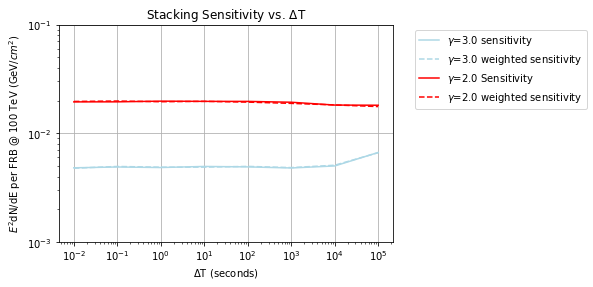

In [49]:
#Making a plot of two different sensitivity calculations. The regular sensitivity has a time window that begins with
#each burst whereas the other sensitivity has a window that is centered on the burst

plt.plot(time_window_plot, sens_gamma_3_perFRB, color = 'lightblue', label = r'$\gamma$=3.0 sensitivity')
plt.plot(time_window_plot, weighted_sens_gamma3_perFRB, color = 'lightblue', label = r'$\gamma$=3.0 weighted sensitivity', linestyle='--')
plt.plot(time_window_plot, sens_gamma_2_perFRB, color = 'red', label = r'$\gamma$=2.0 Sensitivity')
plt.plot(time_window_plot, weighted_sens_gamma2_perFRB, color = 'red', label = r'$\gamma$=2.0 weighted sensitivity', linestyle='--')
plt.grid() #True, which="both", ls="-")
plt.ylim(.001, 0.1)
plt.yscale('log')
plt.xscale('log')
#plt.axvline(x=0.01, color = 'black', linestyle='--')
#plt.axvline(x=1000.0, color = 'black',  linestyle='--')
plt.ylabel(r'$E^{2}$dN/dE per FRB @ 100 TeV (GeV/$cm^{2}$)')
plt.xlabel(r'$\Delta$T (seconds)')
plt.title(r'Stacking Sensitivity vs. $\Delta$T')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.savefig('/data/user/mkovacevich/FRB_analysis/plots/Weighted_Comparison_StackingSensitivity.png')

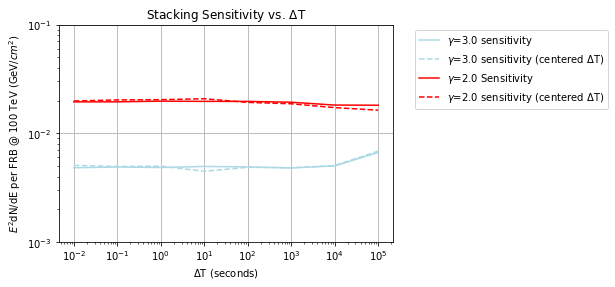

In [50]:
#Making a plot of two different sensitivity calculations. The regular sensitivity has a time window that begins with
#each burst whereas the other sensitivity has a window that is centered on the burst

plt.plot(time_window_plot, sens_gamma_3_perFRB, color = 'lightblue', label = r'$\gamma$=3.0 sensitivity')
plt.plot(time_window_plot, centered_sens_gamma3_perFRB, color = 'lightblue', label = r'$\gamma$=3.0 sensitivity (centered $\Delta$T)', linestyle='--')
plt.plot(time_window_plot, sens_gamma_2_perFRB, color = 'red', label = r'$\gamma$=2.0 Sensitivity')
plt.plot(time_window_plot, centered_sens_gamma2_perFRB, color = 'red', label = r'$\gamma$=2.0 sensitivity (centered $\Delta$T)', linestyle='--')
plt.grid() #True, which="both", ls="-")
plt.ylim(.001, 0.1)
plt.yscale('log')
plt.xscale('log')
#plt.axvline(x=0.01, color = 'black', linestyle='--')
#plt.axvline(x=1000.0, color = 'black',  linestyle='--')
plt.ylabel(r'$E^{2}$dN/dE per FRB @ 100 TeV (GeV/$cm^{2}$)')
plt.xlabel(r'$\Delta$T (seconds)')
plt.title(r'Stacking Sensitivity vs. $\Delta$T')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.savefig('/data/user/mkovacevich/FRB_analysis/plots/Centered_Comparison_StackingSensitivity.png')

In [7]:
#Gamma = 3 sensitivity comparison
#Following arrays are for southern tracks, l2p2 array name will be fixed to show this!
l2p2_sens_time_compare_g3 = [0.010058761926298882,
0.1,
1.0177323697119471,
10.117869148995979,
102.9728294544307,
999.999999999998,
10177.32369711944,
101178.69148995937]
l2p2_sens_time_g3 = [0.005189810676624157,
0.005189810676624157,
0.0052627425025405196,
0.005411695265464649,
0.0055648638769833,
0.005802783448666192,
0.006860624286177796,
0.01198913578187814]

l2p2_sens_time_compare_g2 = [0.010058761926298882,
0.1,
1.0177323697119471,
10.117869148995979,
100.58761926298861,
999.999999999998,
10177.32369711944,
101178.69148995937]

l2p2_sens_time_g2 = [0.014373937679631065,
0.014780766957416678,
0.014780766957416678,
0.014988479413577002,
0.014988479413577002,
0.015629295196512058,
0.0172331090561351,
0.02246545151312211]

stracks_3sig_g3 = [0.005189810676624157,
0.005189810676624157,
0.0052627425025405196,
0.005643066283354779,
0.007153942654376493,
0.010427538888537688,
0.01629750834620645,
0.03184419707833549]
stracks_4sig_g3 = [0.005189810676624157,
0.005336699231206313,
0.006135907273413176,
0.008576958985908946,
0.010000000000000005,
0.0132194114846603,
0.02095135527038037,
0.04037017258596558]
stracks_5sig_g3 = [0.006222134488428773,
0.008340884765952229,
0.009069341548063804,
0.009724757667205179,
0.012501717960549288,
0.016758780942343263,
0.0261927934481563,
0.04977023564332114]

stracks_sens_g2 = [0.014373937679631058,
0.014780766957416662,
0.014780766957416662,
0.014780766957416662,
0.014988479413576988,
0.01584893192461114,
0.0172331090561351,
0.0224654515131221]
stracks_3sig_g2 = [0.014575933009692963,
0.014780766957416662,
0.014575933009692963,
0.015412702225087496,
0.018222420349904157,
0.024770763559917128,
0.03511191734215133,
0.05967021130238474]
stracks_4sig_g2 = [0.014373937679631058,
0.014988479413576988,
0.016526535398566897,
0.02095135527038037,
0.02582981003198078,
0.03184419707833549,
0.04641588833612782,
0.07670938216429443]
stracks_5sig_g2 = [0.016526535398566897,
0.02095135527038037,
0.02442748683397144,
0.0261927934481563,
0.030967709969353545,
0.04037017258596558,
0.05802783448666188,
0.0958999060745998]

#computing sensitivity ratios
gamma_3_ratio = np.divide(sens_gamma_3_perFRB, l2p2_sens_time_g3)
gamma_3_3disc_ratio = np.divide(three_sig_gamma_3_perFRB, stracks_3sig_g3)
gamma_3_4disc_ratio = np.divide(four_sig_gamma_3_perFRB, stracks_4sig_g3)
gamma_3_5disc_ratio = np.divide(five_sig_gamma_3_perFRB, stracks_5sig_g3)

gamma_2_ratio = np.divide(sens_gamma_2_perFRB, stracks_sens_g2)
gamma_2_3disc_ratio = np.divide(three_sig_gamma_2_perFRB, stracks_3sig_g2)
gamma_2_4disc_ratio = np.divide(four_sig_gamma_2_perFRB, stracks_4sig_g2)
gamma_2_5disc_ratio = np.divide(five_sig_gamma_2_perFRB, stracks_5sig_g2)


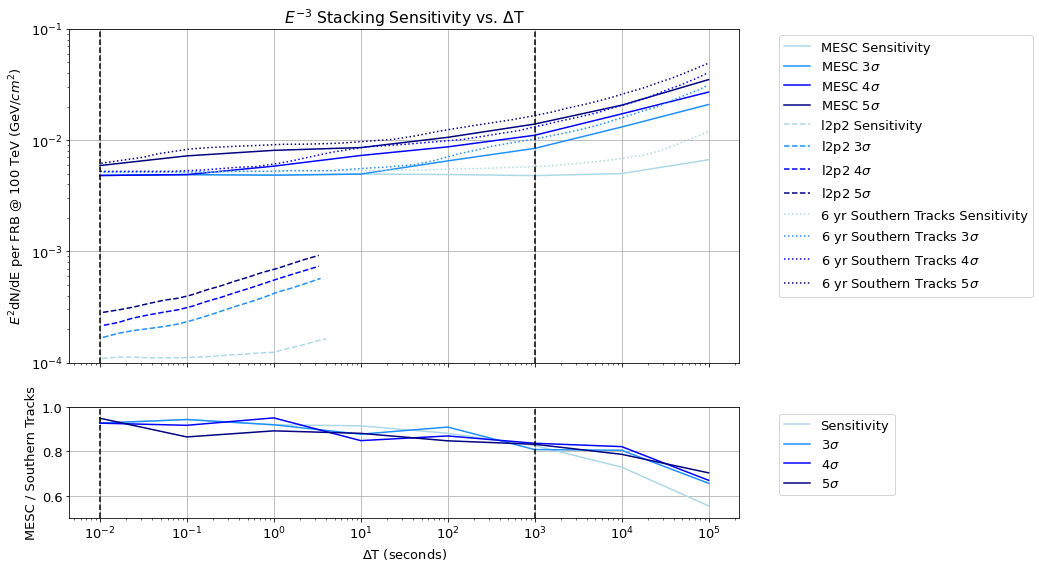

In [57]:
plt.rcParams.update({'font.size': 13})
fig, (ax1, ax2) = plt.subplots(2, figsize=(12,9), gridspec_kw = {'height_ratios':[3, 1]}, sharex=True)
#ax1.subplot(2, 1, 1)
ax1.plot(time_window_plot, sens_gamma_3_perFRB, color = 'lightblue', label = 'MESC Sensitivity')
ax1.plot(time_window_plot, three_sig_gamma_3_perFRB, color = 'dodgerblue', label = r'MESC 3$\sigma$')
ax1.plot(time_window_plot, four_sig_gamma_3_perFRB, color = 'blue', label = r'MESC 4$\sigma$')
ax1.plot(time_window_plot, five_sig_gamma_3_perFRB, color = 'navy', label = r'MESC 5$\sigma$')

ax1.plot(l2p2_gamma3_sens_t, l2p2_gamma3_sens,  color = 'lightblue', linestyle='--', label = r'l2p2 Sensitivity')
ax1.plot(l2p2_gamma3_3sig_t, l2p2_gamma3_3sig, color = 'dodgerblue', linestyle='--', label = r'l2p2 3$\sigma$')
ax1.plot(l2p2_gamma3_4sig_t, l2p2_gamma3_4sig, color = 'blue', linestyle='--', label = r'l2p2 4$\sigma$')
ax1.plot(l2p2_gamma3_5sig_t, l2p2_gamma3_5sig, color = 'navy', linestyle='--', label = r'l2p2 5$\sigma$')

ax1.plot(Tracks_6yr_gamma3_sens_t, Tracks_6yr_gamma3_sens,  color = 'lightblue', linestyle=':',label = r'6 yr Southern Tracks Sensitivity')
ax1.plot(Tracks_6yr_gamma3_3sig_t, Tracks_6yr_gamma3_3sig, color = 'dodgerblue', linestyle=':',label = r'6 yr Southern Tracks 3$\sigma$')
ax1.plot(Tracks_6yr_gamma3_4sig_t, Tracks_6yr_gamma3_4sig, color = 'blue', linestyle=':',label = r'6 yr Southern Tracks 4$\sigma$')
ax1.plot(Tracks_6yr_gamma3_5sig_t, Tracks_6yr_gamma3_5sig, color = 'navy', linestyle=':',label = r'6 yr Southern Tracks 5$\sigma$')


ax1.set_ylim(.0001, 0.1)
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.axvline(x=0.01, color = 'black', linestyle='--')
ax1.axvline(x=1000.0, color = 'black',  linestyle='--')
ax1.set_ylabel(r'$E^{2}$dN/dE per FRB @ 100 TeV (GeV/$cm^{2}$)')
#plt.xlabel(r'$\Delta$T (seconds)')
#ax1.set_xticks(color='white')
ax1.grid(True)
ax1.set_title(r'$E^{-3}$ Stacking Sensitivity vs. $\Delta$T')
ax1.patch.set_facecolor('white')
ax1.legend(bbox_to_anchor=(1.05, 1))
#plt.subplots_adjust(hspace = 3.0)

#ax2.subplot(2, 1, 2)
#ax2.subplots(figsize=(10,5))
ax2.set_ylim(.5, 1.0)
ax2.plot(time_window_plot,gamma_3_ratio, color = 'lightblue', label = 'Sensitivity')
ax2.plot(time_window_plot,gamma_3_3disc_ratio, color = 'dodgerblue', label = '3$\sigma$')
ax2.plot(time_window_plot,gamma_3_4disc_ratio, color = 'blue', label = '4$\sigma$')
ax2.plot(time_window_plot,gamma_3_5disc_ratio, color = 'navy', label = '5$\sigma$')
ax2.set_xscale('log')
ax2.axvline(x=0.01, color = 'black', linestyle='--')
ax2.axvline(x=1000.0, color = 'black',  linestyle='--')
ax2.grid()
ax2.set_ylabel('MESC / Southern Tracks')
ax2.set_xlabel(r'$\Delta$T (seconds)' )
ax2.legend(bbox_to_anchor=(1.05, 1), loc = 2)
fig.patch.set_facecolor('white')

fig.savefig('/home/mkovacevich/public_html/plots/E3StackingSensitivityComparisons.png', bbox_inches='tight')
#plt.subplots_adjust(hspace = 3.0)

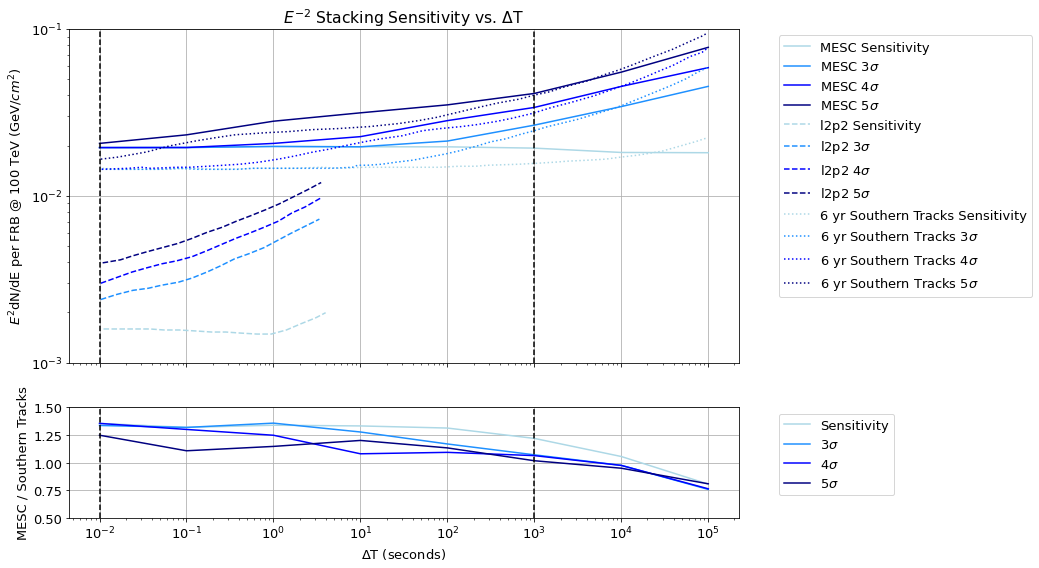

In [14]:
plt.rcParams.update({'font.size': 13})
fig, (ax1, ax2) = plt.subplots(2, figsize=(12,9), gridspec_kw = {'height_ratios':[3, 1]}, sharex=True)

ax1.plot(time_window_plot, sens_gamma_2_perFRB, color = 'lightblue', label = 'MESC Sensitivity')
ax1.plot(time_window_plot, three_sig_gamma_2_perFRB, color = 'dodgerblue', label = r'MESC 3$\sigma$')
ax1.plot(time_window_plot, four_sig_gamma_2_perFRB, color = 'blue', label = r'MESC 4$\sigma$')
ax1.plot(time_window_plot, five_sig_gamma_2_perFRB, color = 'navy', label = r'MESC 5$\sigma$')

ax1.plot(l2p2_gamma2_sens_t, l2p2_gamma2_sens,  color = 'lightblue', linestyle='--', label = r'l2p2 Sensitivity')
ax1.plot(l2p2_gamma2_3sig_t, l2p2_gamma2_3sig, color = 'dodgerblue', linestyle='--', label = r'l2p2 3$\sigma$')
ax1.plot(l2p2_gamma2_4sig_t, l2p2_gamma2_4sig, color = 'blue', linestyle='--', label = r'l2p2 4$\sigma$')
ax1.plot(l2p2_gamma2_5sig_t, l2p2_gamma2_5sig, color = 'navy', linestyle='--', label = r'l2p2 5$\sigma$')

ax1.plot(Tracks_6yr_gamma2_sens_t, Tracks_6yr_gamma2_sens,  color = 'lightblue', linestyle=':',label = r'6 yr Southern Tracks Sensitivity')
ax1.plot(Tracks_6yr_gamma2_3sig_t, Tracks_6yr_gamma2_3sig, color = 'dodgerblue', linestyle=':',label = r'6 yr Southern Tracks 3$\sigma$')
ax1.plot(Tracks_6yr_gamma2_4sig_t, Tracks_6yr_gamma2_4sig, color = 'blue', linestyle=':',label = r'6 yr Southern Tracks 4$\sigma$')
ax1.plot(Tracks_6yr_gamma2_5sig_t, Tracks_6yr_gamma2_5sig, color = 'navy', linestyle=':',label = r'6 yr Southern Tracks 5$\sigma$')


ax1.set_ylim(.001, 0.1)
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.axvline(x=0.01, color = 'black', linestyle='--')
ax1.axvline(x=1000.0, color = 'black',  linestyle='--')
ax1.set_ylabel(r'$E^{2}$dN/dE per FRB @ 100 TeV (GeV/$cm^{2}$)')
ax1.grid(True)
ax1.set_title(r'$E^{-2}$ Stacking Sensitivity vs. $\Delta$T')
ax1.legend(bbox_to_anchor=(1.05, 1)) #bbox_inches='tight')
fig.patch.set_facecolor('white')



ax2.set_ylim(0.5, 1.5)
ax2.plot(time_window_plot,gamma_2_ratio, color = 'lightblue', label = 'Sensitivity')
ax2.plot(time_window_plot,gamma_2_3disc_ratio, color = 'dodgerblue', label = '3$\sigma$')
ax2.plot(time_window_plot,gamma_2_4disc_ratio, color = 'blue', label = '4$\sigma$')
ax2.plot(time_window_plot,gamma_2_5disc_ratio, color = 'navy', label = '5$\sigma$')
ax2.set_xscale('log')
ax2.axvline(x=0.01, color = 'black', linestyle='--')
ax2.axvline(x=1000.0, color = 'black',  linestyle='--')
ax2.grid()
ax2.set_ylabel('MESC / Southern Tracks')
ax2.set_xlabel(r'$\Delta$T (seconds)' )
ax2.legend(bbox_to_anchor=(1.05, 1), loc = 2) #, bbox_inches='tight')
fig.patch.set_facecolor('white')

#fig.savefig('/data/user/mkovacevich/FRB_analysis/plots/E2StackingSensitivityComparisons.png')
fig.savefig('/home/mkovacevich/public_html/plots/E2StackingSensitivityComparisons.png', bbox_inches='tight')

In [38]:
FRB_sindec = [np.sin(x) for x in FRB_dec_rad]

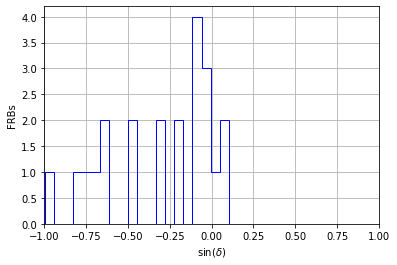

In [45]:
plt.hist(FRB_sindec, histtype = 'step', color = 'b', bins = 20)
plt.grid(True)
plt.xlim(-1.0, 1.0)
plt.ylabel('FRBs')
plt.xlabel(r'sin($\delta$)')
plt.savefig('/home/mkovacevich/public_html/plots/FRB_sindec.png', bbox_inches='tight', facecolor = 'white')

/home/mkovacevich/py3venv/lib/python3.7/site-packages/healpy/projaxes.py:211: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  **kwds
/home/mkovacevich/py3venv/lib/python3.7/site-packages/healpy/projaxes.py:543: UserWarning: 0.0 180.0 -180.0 180.0
  pmin / dtor, pmax / dtor, mmin / dtor, mmax / dtor
/home/mkovacevich/py3venv/lib/python3.7/site-packages/healpy/projaxes.py:658: UserWarning: The interval between parallels is 30 deg -0.00'.
  vdeg, varcmin
/home/mkovacevich/py3venv/lib/python3.7/site-packages/healpy/projaxes.py:666: UserWarning: The interval between meridians is 30 deg -0.00'.
  vdeg, varcmin
/home/mkovacevich/py3venv/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


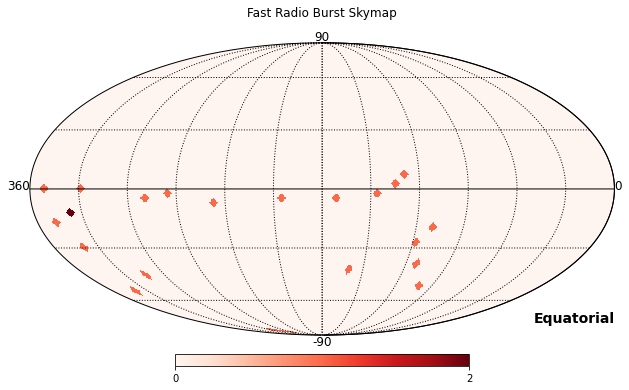

In [43]:
from pylab import arange, show, cm
import healpy as hp
coord = 'C'
rot = (-180,0,0)
m = hp.ang2pix(16, np.pi/2. - np.array(FRB_dec_rad), np.array(FRB_ra_rad), lonlat=False)
def gen_fast_map(ip_,nside=16):
    npixel = hp.nside2npix(nside)
    map_ = np.bincount(ip_,minlength=npixel)
    return map_

map = gen_fast_map(m)
hp.visufunc.mollview(map, cmap = cm.Reds, cbar = True, coord=coord, rot=(180,0,0), margins=(1,1,1,1))
hp.visufunc.graticule(coord=['C'])
#hp.visufunc.projtext(np.radians(120), np.radians(180),color='r',lonlat=False)
hp.projtext(0,0,'90', size='large', ha='center', va='bottom', coord=coord)
hp.projtext(np.pi/2,2.0*np.pi - .001,'360', size='large', ha='right', coord=coord)
hp.projtext(np.pi/2,0,'0', size='large', ha='left', coord=coord)
hp.projtext(np.pi,0,'-90', size='large', ha='center', va='top', coord=coord)
plt.title('Fast Radio Burst Skymap', pad=25)
#plt.figure(facecolor='white')
plt.tight_layout()
plt.savefig('/home/mkovacevich/public_html/plots/FRBhealpy.png')#, bbox_inches='tight')
